In [1]:
import numpy
import pandas
import tensorflow
import keras
from matplotlib import pyplot
import seaborn
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

%matplotlib inline

2022-08-09 07:39:00.303794: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-09 07:39:00.303827: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


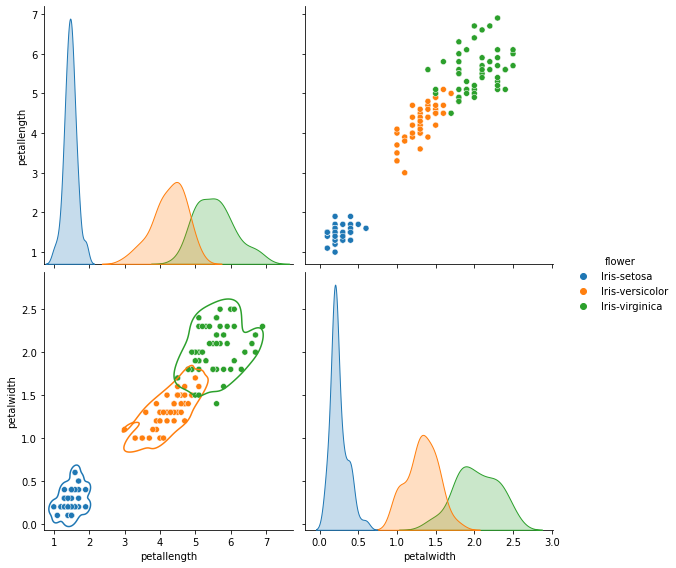

In [44]:
# CLASSIFIER PARAMETERS
my_vars = ['petallength', 'petalwidth']
class_col = 'flower'
my_class = 'Iris-versicolor'

# TRAINING PARAMETERS
max_hidden_neurons = 20
hidden_neuron_activation = 'sigmoid'
my_metric = 'Precision'
my_patience = 100
max_epoch = 10*my_patience
min_improvement = 0.01
min_neuron_gain = 0.025
rmsprop_lr = 0.001
adam_initial_lr = 0.01
adam_decay_steps = max_epoch
adam_lr_decay = 0.9
rollback_on_no_lower_bound_gain = True

# CONTROL RANDOMNESS
random_seed = 33
n_k_folds = 5

# SELECTION FROM IRIS DATAFRAME
my_vars_w_class = my_vars.copy()
my_vars_w_class.append(class_col)
iris = pandas.read_csv('iris.data')
iris = iris[my_vars_w_class]

# SCATTER PLOT
g = seaborn.pairplot(iris, hue='flower', height=4, diag_kind='kde')
_ = g.map_lower(seaborn.kdeplot, levels=1, color=".2")

In [45]:
# ROBUST TRAINING PROCEDURE

# OPTIMIZERS TO COMPARE
adam_lr_schedule = tensorflow.keras.optimizers.schedules.ExponentialDecay(adam_initial_lr, adam_decay_steps, adam_lr_decay)
my_optimizers = {'adam': tensorflow.keras.optimizers.Adam(learning_rate=adam_lr_schedule),
                 'rmsprop': tensorflow.keras.optimizers.RMSprop(learning_rate=rmsprop_lr)}

# SET THE RANDOM SEED
numpy.random.seed(random_seed)
tensorflow.random.set_seed(random_seed)

# PREPARE DATA
X = iris[my_vars].to_numpy()
Y = (iris['flower'] == my_class).astype(float).to_numpy()[:, numpy.newaxis] # 0 / 1

# NORMALIZE VARIABLES
X_scaler = StandardScaler()
X_scaler = X_scaler.fit(X)
X_scaled = X_scaler.transform(X)

# GET STRATIFIED FOLDS
sk_folds = StratifiedKFold(n_splits=n_k_folds)
sk_folds.get_n_splits(X_scaled, Y)

# TRAINING LOOP
# FOR EACH OPTIMIZER
best_net_name = None
best_net = None
best_metric = 0.0
best_metric_val = 0.0
metric_lower_bound = 0.0
result_list = []
print('TRAINING PROCEDURE STARTED...\n')
for n_neuron in numpy.arange(1, max_hidden_neurons+1):
    # FOR 1 TO MAX_HIDDEN_NEURONS
    ix_fold = 1
    for train_index, test_index in sk_folds.split(X_scaled, Y):
        # GET STRATIFIED DATA
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        for optimizer in my_optimizers.keys():
            # DECLARE NET
            inputs = keras.Input(shape=(len(my_vars), ))
            hidden = keras.layers.Dense(n_neuron, activation=hidden_neuron_activation)(inputs)
            outputs = keras.layers.Dense(1, activation='sigmoid')(hidden)
            model_name = '{}-N{}F{}_{}'.format(optimizer.upper(), n_neuron, ix_fold, my_class)
            my_net = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

            # COMPILE NET
            metric_name = my_metric.lower()
            val_metric_name = 'val_{}'.format(metric_name)
            my_net.compile(optimizer=my_optimizers[optimizer], loss='mse', metrics=[my_metric])
            es_loss = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=my_patience, restore_best_weights=True)
            es_metric = tensorflow.keras.callbacks.EarlyStopping(monitor=metric_name, mode='max', patience=my_patience, min_delta=min_improvement)
            es_val_metric = tensorflow.keras.callbacks.EarlyStopping(monitor=val_metric_name, mode='max', patience=n_k_folds*my_patience, min_delta=min_improvement)
            
            # FIT W CLASS WEIGHTS
            my_class_weight = Y_train.shape[0]/Y_train.sum()
            other_class_weight = Y_train.shape[0]/(Y_train==0).sum()
            class_weights = {0: other_class_weight, 1: my_class_weight}
            history = my_net.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=X_train.shape[0], epochs=max_epoch, verbose=0, callbacks=[es_loss, es_metric, es_val_metric], class_weight=class_weights)

            # UNPACK TRAINING RESULTS
            model_loss = history.history['loss'][-1]
            model_val_loss = history.history['val_loss'][-1]
            metric_val = history.history[metric_name][-1]
            val_metric_val = history.history[val_metric_name][-1]
            n_epochs = len(history.history['val_loss'])

            # CHECK IF BEST NET
            best_net_txt = ''
            is_best = False
            if ((metric_val > best_metric + min_improvement) & (val_metric_val >= best_metric_val)) | ((metric_val >= best_metric) & (val_metric_val > best_metric_val + min_improvement)):
                best_net_name = model_name
                best_optimizer = optimizer
                best_net = my_net
                best_neurons = n_neuron
                best_metric = metric_val
                best_metric_val = val_metric_val
                best_net_txt = '**Best NET!**'
                is_best = True

            result_dict = {'model_name': model_name, 'optimizer': optimizer, 'neurons': n_neuron, 'fold': ix_fold, 'loss': model_loss,
                'val_loss': model_val_loss, metric_name: metric_val, val_metric_name: val_metric_val, 'epochs': n_epochs, 'is_best': is_best, 'net': my_net}
            result_list.append(result_dict)

            print('{} > epochs: {} loss: {:.2f} val_loss: {:.2f} {}: {:.0f}% {}: {:.0f}% {}'.format(model_name, n_epochs, model_loss, model_val_loss, metric_name,
                                                                                                  100.0*metric_val, val_metric_name, 100.0*val_metric_val, best_net_txt))

            # IF MAXIMIZED METRICS BREAK
            maximized_metrics = (val_metric_val == 1.0) & (metric_val == 1.0)

            if maximized_metrics:
                break
        
        if maximized_metrics:
            break

        print('')
        ix_fold += 1
        
    # TEST IF MORE NEURONS ARE NECESSARY
    dont_need_extra_neurons = False
    if n_neuron > 1:
        
        # INCREASING NEURONS DIDNT ACHIEVE BEST NET
        if best_neurons < n_neuron:
            dont_need_extra_neurons = True
            print('NETs w {} neurons didnt improve {}!'.format(n_neuron, metric_name))
            break

    # GET LOWER BOUND OF WINNING ALGORITHM
    df_results = pandas.DataFrame(result_list)
    lower_bound_est = df_results[(df_results.optimizer == best_optimizer) & (df_results.neurons == n_neuron)][val_metric_name].min()

    # TEST IF LOWER BOUND IMPROVED
    lower_bound_didnt_improve = False
    if n_neuron > 1:
        neuron_gain = 0.0
        if lower_bound_est > metric_lower_bound:
            if metric_lower_bound > 0.0:
                neuron_gain = lower_bound_est/metric_lower_bound - 1.0
                if neuron_gain <= min_neuron_gain:
                    print('NETs w {} neurons didnt improve min {} {:.1f} neuron gain {:.1f} / min {:.1f}!'.format(n_neuron, val_metric_name, 100.0*lower_bound_est, 100.0*neuron_gain, 100.0*min_neuron_gain))
                    lower_bound_didnt_improve = True
                    break
                else:
                    print('NETs Neuron Gain w/ {} neurons: {:.1f} >> {:.1f} = {:.2f}%'.format(n_neuron, 100.0*metric_lower_bound, 100.0*lower_bound_est ,100.0*neuron_gain))
            else:
                print('NET Neural Gain From 0.0 >> {:.1f}%'.format(100.0*lower_bound_est))
        else:
            print('No Lower Bound Gain on {} neurons for {}: {:.1f} >> {:.1f}'.format(n_neuron, best_optimizer, 100.0*metric_lower_bound, 100.0*lower_bound_est))
            lower_bound_didnt_improve = True
            break
    else:
        print('NET Lower Bound Estimation for {} neuron: {:.1f}%'.format(n_neuron, 100.0*lower_bound_est))
    
    metric_lower_bound = lower_bound_est
    print('')

    if maximized_metrics or dont_need_extra_neurons:
        break

TRAINING PROCEDURE STARTED...

ADAM-N1F1_Iris-versicolor > epochs: 137 loss: 0.45 val_loss: 0.34 precision: 53% val_precision: 31% **Best NET!**
RMSPROP-N1F1_Iris-versicolor > epochs: 101 loss: 0.53 val_loss: 0.36 precision: 33% val_precision: 33% 

ADAM-N1F2_Iris-versicolor > epochs: 120 loss: 0.48 val_loss: 0.32 precision: 47% val_precision: 29% 
RMSPROP-N1F2_Iris-versicolor > epochs: 101 loss: 0.50 val_loss: 0.26 precision: 38% val_precision: 23% 

ADAM-N1F3_Iris-versicolor > epochs: 168 loss: 0.35 val_loss: 0.19 precision: 50% val_precision: 50% 
RMSPROP-N1F3_Iris-versicolor > epochs: 101 loss: 0.50 val_loss: 0.25 precision: 31% val_precision: 30% 

ADAM-N1F4_Iris-versicolor > epochs: 115 loss: 0.34 val_loss: 0.35 precision: 57% val_precision: 33% **Best NET!**
RMSPROP-N1F4_Iris-versicolor > epochs: 101 loss: 0.53 val_loss: 0.25 precision: 33% val_precision: 33% 

ADAM-N1F5_Iris-versicolor > epochs: 104 loss: 0.30 val_loss: 0.37 precision: 57% val_precision: 33% 
RMSPROP-N1F5_Iris-

In [46]:
# ROLL BACK TO LESS NEURON IF DIDNT IMPROVE
if lower_bound_didnt_improve and rollback_on_no_lower_bound_gain:
    best_row = df_results[(df_results.neurons == n_neuron - 1) & df_results.is_best].tail(1)
    best_net_name = best_row['model_name'].values[0]
    best_optimizer = best_row['optimizer'].values[0]
    best_net = best_row['net'].values[0]
    best_neurons = best_row['neurons'].values[0]
    best_metric = best_row[metric_name].values[0]
    best_metric_val = best_row[val_metric_name].values[0]

In [47]:
# CLASS COLOR GRID & CLASS EVALUATION
grid_n_points = 100
class_threshold = 0.5
little_delta = 0.1
jitter_factor = 0.1
rect_expansion = 1.1

# X0 W JITTER
x0_grid = numpy.linspace(0, rect_expansion*(X[:, 0].max()), grid_n_points)
x0_jitter = jitter_factor*(x0_grid[1] - x0_grid[0])
x1_grid = numpy.linspace(0, rect_expansion*(X[:, 1].max()), grid_n_points)
x1_jitter = jitter_factor*(x1_grid[1] - x1_grid[0])
X_g = numpy.array(list(itertools.product(x0_grid, x1_grid)))
X_g[:, 0] += x0_jitter*numpy.random.randn(X_g.shape[0])
X_g[:, 1] += x1_jitter*numpy.random.randn(X_g.shape[0])
X_g_scaled = X_scaler.transform(X_g)
Y_g = best_net.predict(X_g_scaled)
Y_est = (best_net.predict(X_scaled) > class_threshold).astype(int)
t_error, t_statistic = best_net.evaluate(X_scaled, Y, verbose=0)

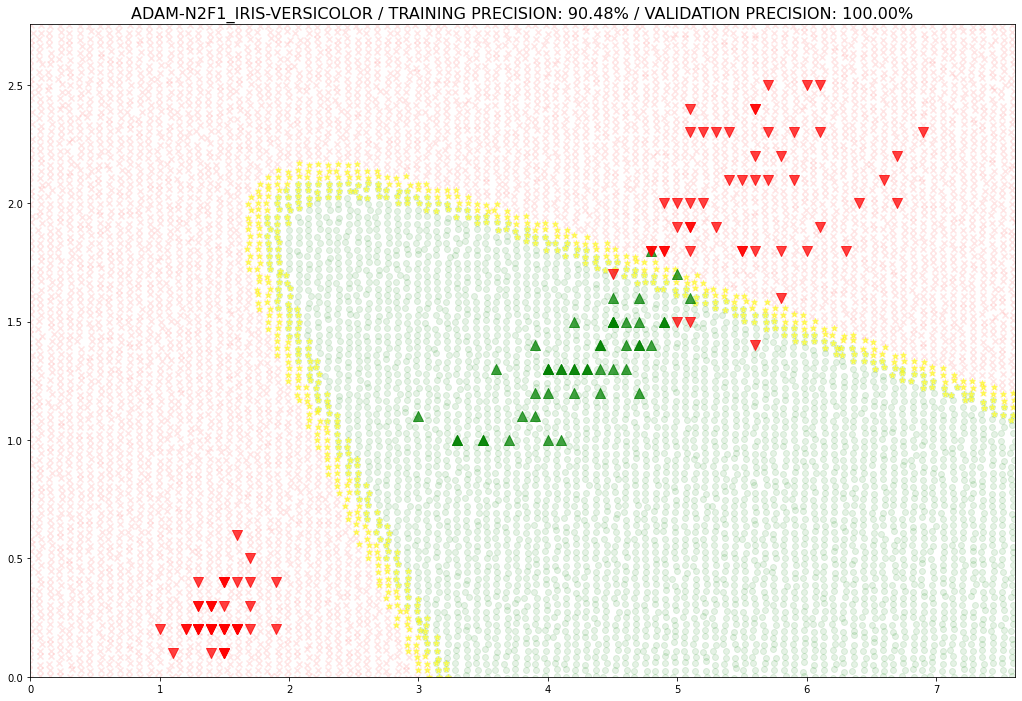

In [48]:
# CLASSIFICATION FIGURE
fig = pyplot.figure(figsize=(12/0.68, 12))
ax = fig.add_subplot(111)
# PLOT CLASS REGION
ix_class_region = Y_g.reshape(-1) > class_threshold
ix_class_points = Y.reshape(-1) == 1
ix_surface = (Y_g.reshape(-1) >= class_threshold - little_delta) &  (Y_g.reshape(-1) <= class_threshold + little_delta)
_ = ax.scatter(X_g[ix_class_region, 0], X_g[ix_class_region, 1], marker='o', color='green', alpha=0.1)
_ = ax.scatter(X_g[~ix_class_region, 0], X_g[~ix_class_region, 1], marker='x', color='red', alpha=0.1)
_ = ax.scatter(X_g[ix_surface, 0], X_g[ix_surface, 1], marker='*', color='yellow', alpha=0.5)
_ = ax.scatter(X[ix_class_points, 0], X[ix_class_points, 1], marker='^', color='green', alpha=0.75, s=100)
_ = ax.scatter(X[~ix_class_points, 0], X[~ix_class_points, 1], marker='v', color='red', alpha=0.75, s=100)
_ = ax.set_xlim([0.0, X_g[:, 0].max()])
_ = ax.set_ylim([0.0, X_g[:, 1].max()])
_ = ax.set_title('{} / training {}: {:.2f}% / validation {}: {:.2f}%'.format(best_net_name, metric_name, 100.0*best_metric, metric_name,100.0*best_metric_val).upper(), size=16)